<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/Behaviour_Classification_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Seabird Diving Behaviour with GPS data


Auto Encoder with Deep Networks


In [2]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
%cd drive/My\ Drive/BirdDL

/content/drive/My Drive/BirdDL


## Data Formatting

In [20]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import random
import pickle
import datetime

import trip

In [5]:
# connect to database
conn = sqlite3.connect('/content/drive/My Drive/data/seabirdbank.db')

In [6]:
request = "SELECT DISTINCT lon, lat FROM fieldwork WHERE place='Pescadores'"
colony = pd.read_sql_query(request, conn)
colony = colony.values
colony

array([[-77.264, -11.773]])

In [8]:
request = "SELECT \
            trip.id as trip, gps.datetime, gps.lon, gps.lat\
            FROM gps \
            INNER JOIN trip ON gps.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND substr(bird.fieldwork,1,1) = 'P' \
            AND bird.species = 'SV'"

# substr(bird.fieldwork,1,1) = 'P'

gps = pd.read_sql_query(request, conn)
gps

,trip,datetime,lon,lat
0,P1108_1_SV_T1,2008-11-23 12:53:38,-77.265178,-11.775134
1,P1108_1_SV_T1,2008-11-23 12:53:39,-77.265222,-11.775064
2,P1108_1_SV_T1,2008-11-23 12:53:40,-77.265312,-11.774998
3,P1108_1_SV_T1,2008-11-23 12:53:41,-77.265384,-11.774966
4,P1108_1_SV_T1,2008-11-23 12:53:42,-77.265506,-11.774930
...,...,...,...,...
2130760,P1115_25_SV_T1,2015-11-28 20:26:40,-77.258705,-11.770595
2130761,P1115_25_SV_T1,2015-11-28 20:26:41,-77.258766,-11.770683
2130762,P1115_25_SV_T1,2015-11-28 20:26:42,-77.258850,-11.770755
2130763,P1115_25_SV_T1,2015-11-28 20:26:43,-77.258934,-11.770796


In [9]:
# check duplicated datetime in GPS trip
idx = gps.index[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]
idx_drop = [idx[i] for i in range(0, len(idx), 2)]
gps = gps.drop(idx_drop)

In [10]:
gps[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]

,trip,datetime,lon,lat
717806,P1110_54_SV_T5,2010-12-05 17:24:55,-77.387550,-11.448993
717808,P1110_54_SV_T5,2010-12-05 17:24:55,-77.387503,-11.448995


In [11]:
# check duplicated datetime in GPS trip
idx = gps.index[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]
idx_drop = [idx[i] for i in range(0, len(idx), 2)]
gps = gps.drop(idx_drop)

In [12]:
gps[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]

,trip,datetime,lon,lat


In [13]:
gps['datetime'] = pd.to_datetime(gps['datetime'], format='%Y-%m-%d %H:%M:%S')

In [14]:
# check NaN and fill with interpolations
[i for i, x in enumerate(gps['lon'].isna()) if x]


gps['lon'] = gps['lon'].interpolate(method='polynomial', order=2)
gps['lat'] = gps['lat'].interpolate(method='polynomial', order=2)

In [15]:
len(gps.trip.unique())

560

In [16]:
bad_trip = ['P1108_2_SV_T3', 'P1108_14_SV_T1', 'P1108_14_SV_T3',
            'P1108_19_SV_T1', 'P1108_19_SV_T2', 'P1108_24_SV_T2',
            'P1108_24_SV_T4', 'P1108_33_SV_T3', 'P1108_38_SV_T5',
            'P1108_39_SV_T2', 'P1108_41_SV_T3', 'P1108_41_SV_T4',
            'P1109_9_SV_T2', 'P1109_16_SV_T5', 'P1110_24_SV_T1',
            'P1110_24_SV_T2', 'P1110_43_SV_T6', 'P1110_47_SV_T2',
            'P1110_47_SV_T4', 'P1110_51_SV_T6', 'P1110_52_SV_T6',
            'P1110_59_SV_T4', 'P1110_59_SV_T6', 'P1110_59_SV_T7',
            'P1110_62_SV_T3', 'P1110_62_SV_T4', 'P1110_64_SV_T1',
            'P1110_64_SV_T2', 'P1110_64_SV_T5', 'P1110_64_SV_T8',
            'P1110_67_SV_T2', 'P1111_41_SV_T5', 'P1111_46_SV_T5',
            'P1112_36_SV_T2', 'P1113_50_SV_T2', 'P1115_SV_T1'          
           ]

In [17]:
### remove bad data
idx = gps.index[[(t in bad_trip) for t in gps.trip]]
df = gps.drop(idx)

In [18]:
len(df.trip.unique())

525

## Dive Prediction

In [21]:
trajs = []
n = 0
for k in gps.trip.unique():
    df_trip = gps[gps.trip == k]

    t = trip.Trip(df_trip)
    # add variables
    t.add_step()
    t.add_cap()
    t.add_direction()
    t.df['cos_cap'] = np.cos(t.df.cap)
    t.df['sin_cap'] = np.sin(t.df.cap)

    # standardized trajectories
    t.standardize(('step', 'direction'))
    t.standardize_minmax(('lon', 'lat'))

    trajs.append(t.df)
    n +=1
    
    IPython.display.clear_output(wait=True)
    print('Trip [{}/{}]'.format(n, len(gps.trip.unique())))

Trip [560/560]


In [26]:
test_trajs_idx = np.random.randint(0, len(gps.trip.unique()), 100)

test_trajs = [trajs[i] for i in test_trajs_idx]
train_trajs = [trajs[i] for i in range(len(gps.trip.unique())) if i not in test_trajs_idx]

## Neural Network

In [23]:
# pytorch materials
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [29]:
class Sampler:
  def __init__(self, trajs, epoch, batch_size, input_var):
    # raw trajectories
    self.trajs = trajs
    self.n = len(trajs)
    # sample input specificities
    self.epoch = epoch
    self.batch_size = batch_size
    self.input_var = input_var

  def sample(self):
    batch = []
    for i in range(self.batch_size):
      # look for a long trip
      dt = []
      while len(dt) < epoch:
        traj_idx = np.random.randint(self.n)
        dt = self.trajs[traj_idx]

      # select part of this trip
      epoch_idx = np.random.randint(2, len(dt)-epoch)
      extracted_trajs = dt.loc[epoch_idx:epoch_idx+epoch-1, self.input_var]

      # add it to batch
      batch.append(extracted_trajs.to_numpy().T)

    return torch.FloatTensor(batch)

In [31]:
# Hyperparameters
epoch = 600
batch_size = 8
learning_rate = 0.01
input_var = ('lon_std_mm', 'lat_std_mm', 'step_std', 'direction_std', 'cos_cap', 'sin_cap')

train = Sampler(train_trajs, epoch, batch_size, input_var)
test = Sampler(test_trajs, epoch, batch_size, input_var)

x = train.sample()
x.size()

torch.Size([8, 6, 600])

In [143]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(6, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),

            nn.MaxPool1d(kernel_size = 11, stride = 2, padding = 5, dilation = 1),

            nn.Conv1d(8, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),

            nn.MaxPool1d(kernel_size = 11, stride = 2, padding = 5, dilation = 1),

            nn.Conv1d(16, 32, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),

            nn.MaxPool1d(kernel_size = 11, stride = 2, padding = 5, dilation = 4),

            nn.Conv1d(32, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 3, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.Softmax(dim=1)
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(3, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),

            nn.ConvTranspose1d(32, 32, kernel_size = 12, stride = 2, padding = 1, dilation = 3),

            nn.Conv1d(32, 32, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),

            nn.ConvTranspose1d(16, 16, kernel_size = 12, stride = 2, padding = 5, dilation = 1),

            nn.Conv1d(16, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),

            nn.ConvTranspose1d(8, 8, kernel_size = 12, stride = 2, padding = 5, dilation = 1),

            nn.Conv1d(8, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 6, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
        )

        
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [147]:
model = ConvNet()
out = model.encoder(x)
out = model.decoder(out)
x.size()

torch.Size([8, 6, 600])

In [148]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [150]:
criterion(out, x)

tensor(0.6752, grad_fn=<MseLossBackward>)

In [151]:
## estimate a relevant nb of total step
total_step = round(0.7 * (len(gps) - len(gps.trip.unique()) * epoch)/batch_size)
total_step

155384

In [152]:
# Train the model
for i in range(total_step):
    
    # Train the model
    model.train()
    x = train.sample() 
    # x, y = x.to(device), y.to(device)

    # Run the forward pass
    out = model(x)
    loss = criterion(out, x)

    # Backprop and perform optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%1000 ==0:
        print('Step [{}/{}], Loss: {:.4f}'
              .format(i + 1, total_step, loss.item()))

Step [1/155384], Loss: 0.6705
Step [1001/155384], Loss: 0.4763
Step [2001/155384], Loss: 0.4858
Step [3001/155384], Loss: 0.4662
Step [4001/155384], Loss: 0.5006
Step [5001/155384], Loss: 0.4151
Step [6001/155384], Loss: 0.5108
Step [7001/155384], Loss: 0.5491
Step [8001/155384], Loss: 0.4971
Step [9001/155384], Loss: 0.5812
Step [10001/155384], Loss: 0.5419
Step [11001/155384], Loss: 0.4816


KeyboardInterrupt: ignored

In [155]:
true = test.sample()
estim = model(true).detach()

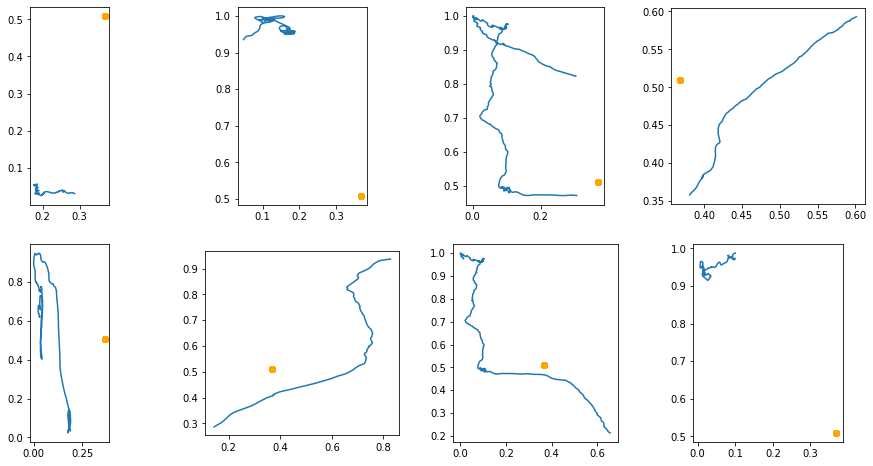

In [158]:
plt.figure(figsize=(16, 8))

for i in range(8):
    
    pos_true = true[i]
    pos_estim = estim[i]
    
    
    plt.subplot(2, 4, i+1)
    plt.plot(pos_true[0,:].numpy(), pos_true[1,:].numpy())
    plt.scatter(pos_estim[0,:].numpy(), pos_estim[1,:].numpy(), c = 'orange')
    
        #selecting the current axis
    ax = plt.gca()
    ax.set_aspect(1)

In [159]:
pos_estim

tensor([[ 0.3683,  0.3683,  0.3683,  ...,  0.3683,  0.3683,  0.3683],
        [ 0.5095,  0.5095,  0.5095,  ...,  0.5095,  0.5095,  0.5095],
        [-0.0743, -0.0743, -0.0743,  ..., -0.0743, -0.0743, -0.0743],
        [ 0.0068,  0.0068,  0.0068,  ...,  0.0068,  0.0068,  0.0068],
        [ 0.0225,  0.0225,  0.0225,  ...,  0.0225,  0.0225,  0.0225],
        [-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006]])